In [1]:
import datetime
import pandas as pd
import numpy as np
import urllib
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.patheffects as PathEffects

In [2]:
# load daily btc data from cbpro and update daily price csv with any new data
df = pd.read_csv('../../github-bitcoin-scripts/bitcoin-data/bitcoin-daily-data.csv')
orig_dates = df['date'].to_list()
df.tail(3)

,date,price
4829,3/25/22,44473.47
4830,3/26/22,44930.29
4831,3/27/22,46949.84


In [3]:
def str_to_datetime(strs):
    """Convert a list of "YYYY-MM-DD" strings to datetime objects."""
    dates = []
    for date in strs:
        if '-' in date:
            y, m, d = (int(x) for x in date.split("-"))
        elif '/' in date:
            m, d, y = int(date.split('/')[0]), int(date.split('/')[1]), \
            int(date.split('/')[2])+2000
        date = datetime.datetime(y, m, d)
        dates.append(date)
    return dates

datetimes = str_to_datetime(orig_dates)
dates = [mdates.date2num(date) for date in datetimes]

In [4]:
def x_axis_dates(ax=None, fig=None):
    """Helper function to format the x axis as dates.

    Input:
    ax:  An Axes instance or an iterable of Axes instances.
    Optional, defaults to plt.gca()
    fig: The Figure instance containing those Axes or Axeses
    Optional, defaults to plt.gcf()
    """
    if ax is None: ax = plt.gca()
    if fig is None: fig = plt.gcf()
    loc = mdates.AutoDateLocator()
    fmt = mdates.AutoDateFormatter(loc)
    try:
        ax.xaxis.set_major_locator(loc)
        ax.xaxis.set_major_formatter(fmt)
    except AttributeError:
        for a in ax:
            # Fresh locators/formatters are needed for each instance
            loc = mdates.AutoDateLocator()
            fmt = mdates.AutoDateFormatter(loc)
            a.xaxis.set_major_locator(loc)
            a.xaxis.set_major_formatter(fmt)
    fig.autofmt_xdate()

In [5]:
URL = "https://api.alternative.me/fng/?limit=0"
with urllib.request.urlopen(URL) as url:
    data = json.loads(url.read().decode())
fg_df = pd.json_normalize(data['data'])
dates = []
for i in range(len(fg_df)):
    timestamp = int(fg_df['timestamp'].iloc[i])
    year = str(datetime.datetime.fromtimestamp(timestamp).year)
    month = str(datetime.datetime.fromtimestamp(timestamp).month)
    day = str(datetime.datetime.fromtimestamp(timestamp).day)
    if len(month) == 1:
        month = '0' + month
    if len(day) == 1:
        day = '0' + day
    date = '%s/%s/%s' % (month, day, year[2:])
    dates.append(date)
fg_df['date'] = dates
fg_df = fg_df.drop(columns=['time_until_update'])
orig_dates = fg_df['date']
fg_df['value'] = fg_df['value'].astype(int)

datetimes = str_to_datetime(orig_dates)
dates = [mdates.date2num(date) for date in datetimes]
fg_values = fg_df['value'].to_list()
fg_df.head(3)

,value,value_classification,timestamp,date
0,60,Greed,1648425600,03/27/22
1,49,Neutral,1648339200,03/26/22
2,51,Neutral,1648252800,03/25/22


In [6]:
def fg_plot(end_ind):
    # days = len(dates)
    days = list(orig_dates).index('01/01/20')+1
    x = dates[:days]
    y = fg_values[:days]
    z = np.array(y)

    cmap = cm.get_cmap('inferno', 100)
    mf = 0.85

    res = (1920, 1280)
    size = res[0]/96.
    size_y = res[1]/96.

    # create figure and axis objects with subplots()
    fig, (ax) = plt.subplots(1, 1, figsize=(size, size_y), dpi=96, facecolor='black')
    ax.set_facecolor("black")
    for spine in ax.spines.values():
        spine.set_edgecolor('w')

    plt.rc('axes', axisbelow=True)

    orig_price_dates = df['date']
    price_datetimes = str_to_datetime(orig_price_dates)
    price_dates = [mdates.date2num(dt) for dt in price_datetimes]
    prices = df['price']

    x = list(price_dates[-1*days:])
    x.reverse()
    y = list(prices[-1*days:])
    y.reverse()

    for i in range(100):
        plt.fill_between(x[-1*end_ind:], y[-1*end_ind:], [0]*len(y[-1*end_ind:]),
                         color=cmap(i/100.*mf),
                         where=((z[-1*end_ind:]>=[i-1]*len(fg_values[:days][-1*end_ind:])) &
                                (z[-1*end_ind:]<[i+1]*len(fg_values[:days][-1*end_ind:]))),
                         interpolate=True, zorder=2)
    for i in range(100):
        plt.fill_between(x[-1*end_ind:], [0]*len(y[-1*end_ind:]), y[-1*end_ind:],
                         color=cmap(i/100.*mf),
                         where=((z[-1*end_ind:]>=[i-1]*len(fg_values[:days][-1*end_ind:])) &
                                (z[-1*end_ind:]<[i+1]*len(fg_values[:days][-1*end_ind:]))),
                         interpolate=True, zorder=2)

    for i in range(len(x[-1*end_ind:])-1):
        for j in range(10):
            plt.plot([x[-1*end_ind:][i]+j*(x[-1*end_ind:][i+1]-x[-1*end_ind:][i])/10,
                      x[-1*end_ind:][i]+(j+1)*(x[-1*end_ind:][i+1]-x[-1*end_ind:][i])/10],
                     [y[-1*end_ind:][i]+j*(y[-1*end_ind:][i+1]-y[-1*end_ind:][i])/10,
                      y[-1*end_ind:][i]+(j+1)*(y[-1*end_ind:][i+1]-y[-1*end_ind:][i])/10],
                     color=cmap((z[-1*end_ind:][i]+j*(z[-1*end_ind:][i+1]-z[-1*end_ind:][i])/10)/
                                100.*mf), lw=2, zorder=5)
            plt.plot([x[-1*end_ind:][i]+j*(x[-1*end_ind:][i+1]-x[-1*end_ind:][i])/10,
                      x[-1*end_ind:][i]+(j+1)*(x[-1*end_ind:][i+1]-x[-1*end_ind:][i])/10],
                     [y[-1*end_ind:][i]+j*(y[-1*end_ind:][i+1]-y[-1*end_ind:][i])/10,
                      y[-1*end_ind:][i]+(j+1)*(y[-1*end_ind:][i+1]-y[-1*end_ind:][i])/10],
                     color='w', lw=4, zorder=4, alpha=0.25)
            
    if len(x[-1*end_ind:]) > 1:
        for i in range(len(x[-1*end_ind:])):
            plt.plot([x[-1*end_ind:][i], x[-1*end_ind:][i], x[-1*end_ind:][i]-1],
                     [0, y[-1*end_ind:][i], 0], color=cmap(z[-1*end_ind:][i]/100.*mf),
                     zorder=3)

    labels = ['$0 / 100', '75', '50', '25', '0']+["$%s" % format(int(item), ',d') for item in 
                                 [10000, 20000, 30000, 40000, 50000, 60000, 70000]]
    max_ylim = max(y)*1.1
    plt.yticks([0, -0.3*max_ylim/4, -0.3*max_ylim/4*2, -0.3*max_ylim/4*3, -0.3*max_ylim,
                10000, 20000, 30000, 40000, 50000, 60000, 70000], labels, fontsize=20, color='w')
    plt.xticks(fontsize=20, color='w')
    plt.xlim(min(x), max(x)+1)
    txt = plt.text(min(x)+0.9825*(max(x)-min(x)), 2000, 'Wicked Smart Bitcoin@w_s_bitcoin',
                   fontsize=32, horizontalalignment='right', color='white')
    txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='black', alpha=0.5)])
    plt.plot(x[-1*end_ind:], y[-1*end_ind:], color='w', lw=4, alpha=0.25, zorder=1)
    plt.grid(color='w', lw=1, linestyle='-', alpha=0.35)
    disp_date = datetime.date(int(orig_dates[days-end_ind].split('/')[2])+2000,
                              int(orig_dates[days-end_ind].split('/')[0]),
                              int(orig_dates[days-end_ind].split('/')[1]))
    plt.text(min(x)+(max(x)-min(x))/8, max_ylim*1.115, 'Date', fontsize=20,
             horizontalalignment='center', verticalalignment='bottom', color='w')
    plt.text(min(x)+(max(x)-min(x))/8, max_ylim*1.035, disp_date.strftime('%b %-d, %Y'),
             fontsize=32, horizontalalignment='center', verticalalignment='bottom', color='w')
    
    plt.text(min(x)+(max(x)-min(x))/8*3, max_ylim*1.115, 'Price', fontsize=20,
             horizontalalignment='center', verticalalignment='bottom', color='w')
    plt.text(min(x)+(max(x)-min(x))/8*3, max_ylim*1.035,
             '$%s' % format(prices[len(prices)-days+end_ind-1], ',.2f'),
             fontsize=32, horizontalalignment='center', verticalalignment='bottom', color='w')
    
    plt.text(min(x)+(max(x)-min(x))/8*5, max_ylim*1.115, 'Fear & Greed Index', fontsize=20,
             horizontalalignment='center', verticalalignment='bottom', color='w')
    txt = plt.text(min(x)+(max(x)-min(x))/8*5, max_ylim*1.035, fg_values[days-end_ind],
                   fontsize=32, horizontalalignment='center', verticalalignment='bottom',
                   color=cmap(fg_values[days-end_ind]/100.*mf))
    txt.set_path_effects([PathEffects.withStroke(linewidth=1.5, foreground='w', alpha=1)])

    if fg_values[days-end_ind] < 25:
        market_sentiment = 'Extreme Fear'
    elif fg_values[days-end_ind] < 45:
        market_sentiment = 'Fear'
    elif fg_values[days-end_ind] <= 55:
        market_sentiment = 'Neutral'
    elif fg_values[days-end_ind] <= 75:
        market_sentiment = 'Greed'
    else:
        market_sentiment = 'Extreme Greed'
    
    plt.text(min(x)+(max(x)-min(x))/8*7, max_ylim*1.115, 'Market Sentiment', fontsize=20,
             horizontalalignment='center', verticalalignment='bottom', color='w')
    txt = plt.text(min(x)+(max(x)-min(x))/8*7, max_ylim*1.035, market_sentiment,
                   fontsize=32, horizontalalignment='center', verticalalignment='bottom',
                   color=cmap(fg_values[days-end_ind]/100.*mf))
    txt.set_path_effects([PathEffects.withStroke(linewidth=1.5, foreground='w', alpha=1)])

    x = dates[:days]
    y = fg_values[:days]
    z = np.array(y)
    for i in range(len(x[-1*end_ind:])-1):
        for j in range(10):
            plt.plot([x[-1*end_ind:][i]+j*(x[-1*end_ind:][i+1]-x[-1*end_ind:][i])/10,
                      x[-1*end_ind:][i]+(j+1)*(x[-1*end_ind:][i+1]-x[-1*end_ind:][i])/10],
                     [(y[-1*end_ind:][i]+j*(y[-1*end_ind:][i+1]-y[-1*end_ind:][i])/10)/
                      100*0.3*max_ylim-0.3*max_ylim,
                      (y[-1*end_ind:][i]+(j+1)*
                       (y[-1*end_ind:][i+1]-y[-1*end_ind:][i])/10)/100*0.3*max_ylim-0.3*max_ylim],
                     color=cmap((y[-1*end_ind:][i]+j*(y[-1*end_ind:][i+1]-y[-1*end_ind:][i])/10)/
                                100.*mf), lw=2, zorder=2)
            plt.plot([x[-1*end_ind:][i]+j*(x[-1*end_ind:][i+1]-x[-1*end_ind:][i])/10,
                      x[-1*end_ind:][i]+(j+1)*(x[-1*end_ind:][i+1]-x[-1*end_ind:][i])/10],
                     [(y[-1*end_ind:][i]+j*(y[-1*end_ind:][i+1]-y[-1*end_ind:][i])/10)/
                      100*0.3*max_ylim-0.3*max_ylim,
                      (y[-1*end_ind:][i]+(j+1)*
                       (y[-1*end_ind:][i+1]-y[-1*end_ind:][i])/10)/100*0.3*max_ylim-0.3*max_ylim],
                     color='w', lw=4, zorder=1, alpha=0.25)

    plt.plot([x[0], x[-1]], [0, 0], color='w', lw=1)
    
    plt.text(min(x)-(max(x)-min(x))*0.1, -0.3*max_ylim/4*6.1, 'test', color='black')
    plt.text(max(x)+(max(x)-min(x))*0.03, max_ylim*1.285, 'test', horizontalalignment='right',
             color='black')

    plt.ylim(-0.3*max_ylim, max_ylim)
    plt.text(min(x)+(max(x)-min(x))/8*4, max_ylim*1.21, 'Bitcoin Fear & Greed (2020s)',
             fontsize=40, color='w', horizontalalignment='center')

    x_axis_dates()
    plt.tight_layout()

    fig.savefig('bitcoin-fear-and-greed.png')

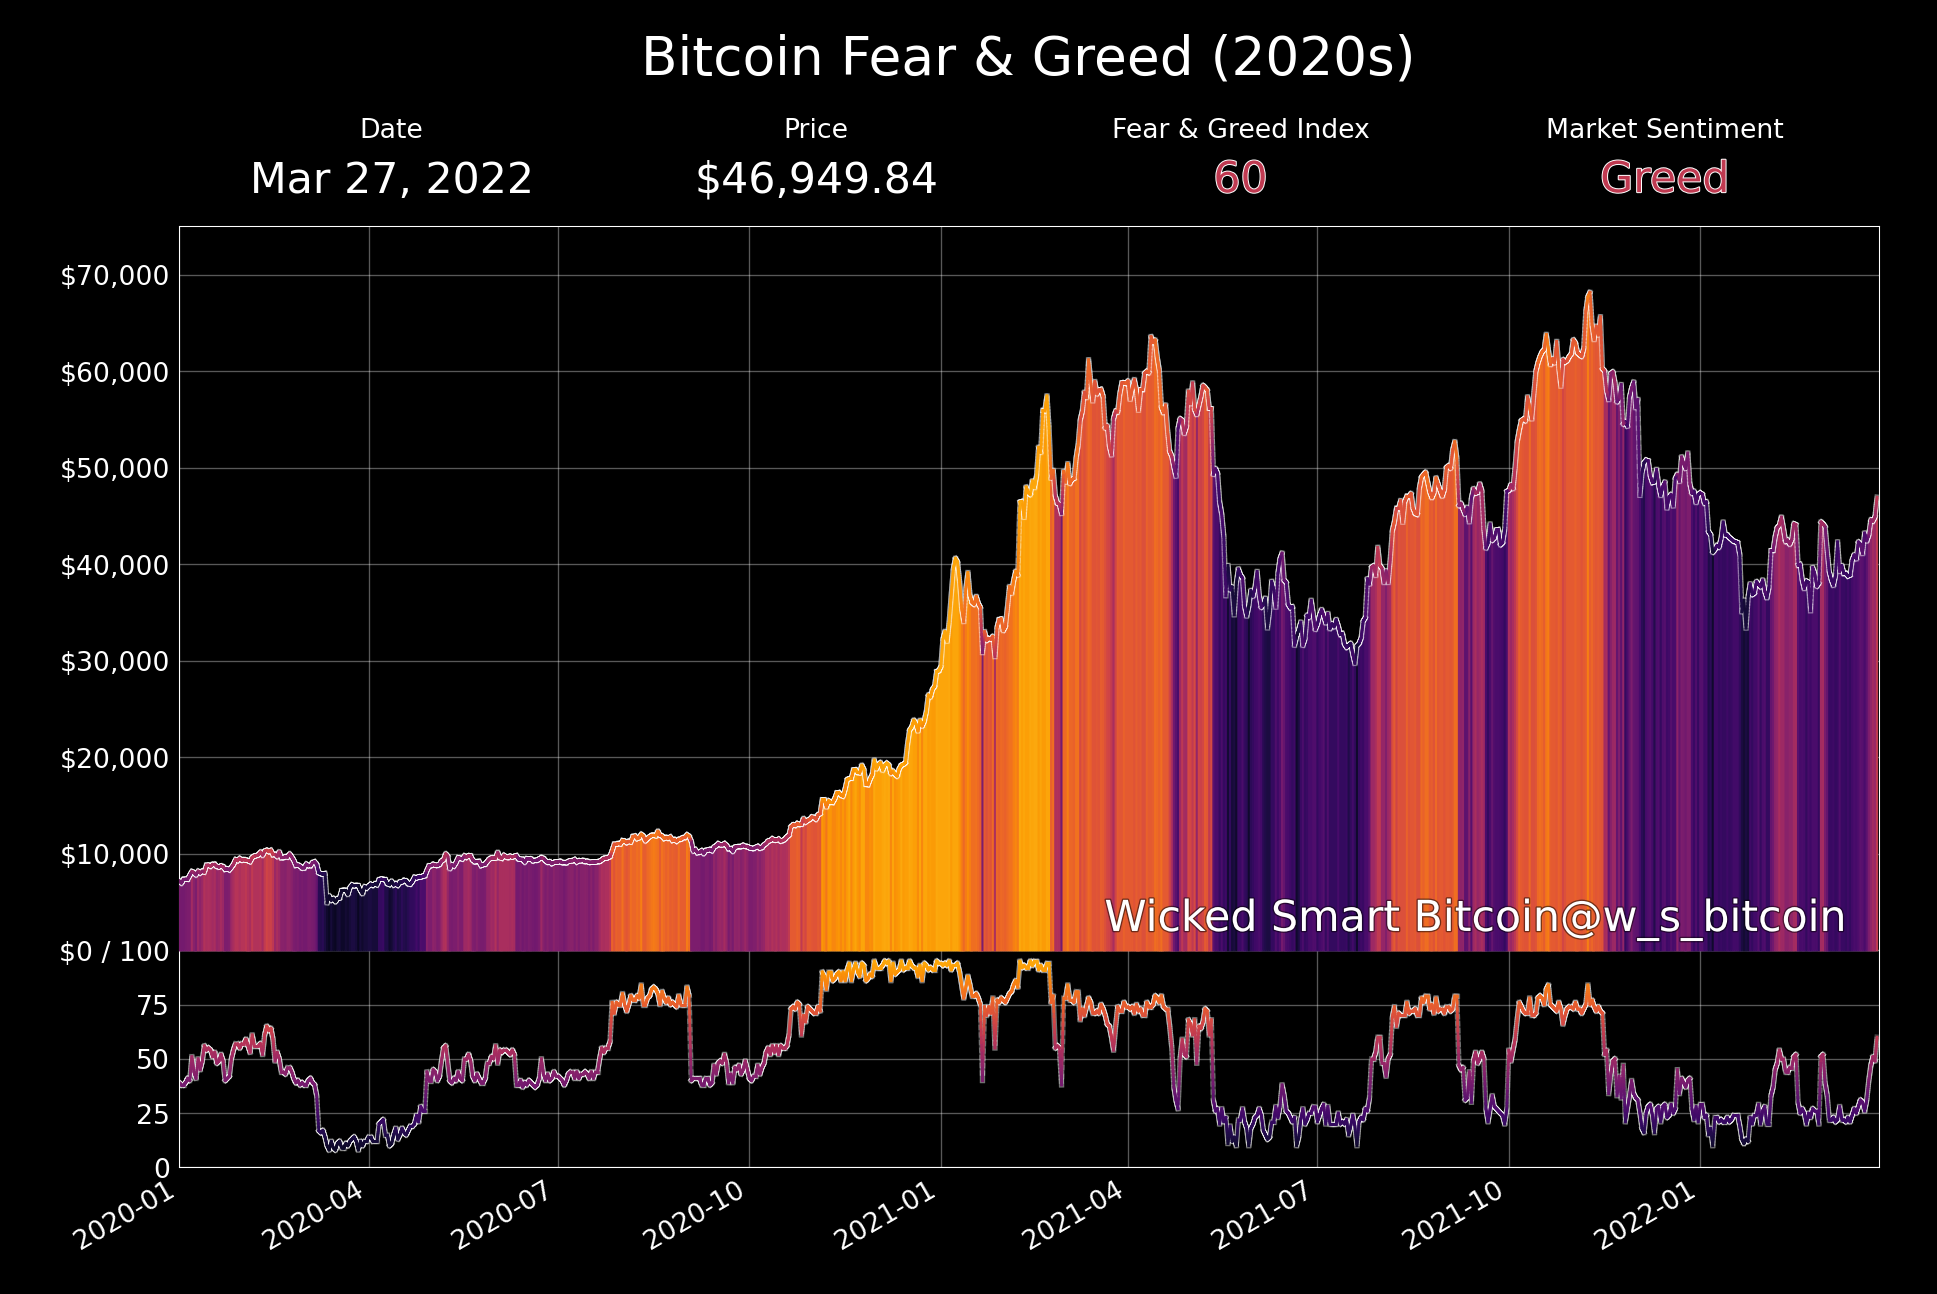

In [7]:
fg_plot(list(orig_dates).index('01/01/20')+1)
# fg_plot(72)

In [8]:
def fg_plot_v2(end_ind):
    # days = len(dates)
    days = end_ind
    x = dates[:days]
    y = fg_values[:days]
    z = np.array(y)

    cmap = cm.get_cmap('inferno', 100)
    mf = 0.85

    res = (1920, 1280)
    size = res[0]/96.
    size_y = res[1]/96.

    # create figure and axis objects with subplots()
    fig, (ax) = plt.subplots(1, 1, figsize=(size, size_y), dpi=96, facecolor='black')
    ax.set_facecolor("black")
    for spine in ax.spines.values():
        spine.set_edgecolor('w')

    plt.rc('axes', axisbelow=True)

    orig_price_dates = df['date']
    price_datetimes = str_to_datetime(orig_price_dates)
    price_dates = [mdates.date2num(dt) for dt in price_datetimes]
    prices = df['price']

    x = list(price_dates[-1*days:])
    x.reverse()
    y = list(prices[-1*days:])
    y.reverse()

    for i in range(100):
        plt.fill_between(x[-1*end_ind:], y[-1*end_ind:], [0]*len(y[-1*end_ind:]),
                         color=cmap(i/100.*mf),
                         where=((z[-1*end_ind:]>=[i-1]*len(fg_values[:days][-1*end_ind:])) &
                                (z[-1*end_ind:]<[i+1]*len(fg_values[:days][-1*end_ind:]))),
                         interpolate=True, zorder=2)
    for i in range(100):
        plt.fill_between(x[-1*end_ind:], [0]*len(y[-1*end_ind:]), y[-1*end_ind:],
                         color=cmap(i/100.*mf),
                         where=((z[-1*end_ind:]>=[i-1]*len(fg_values[:days][-1*end_ind:])) &
                                (z[-1*end_ind:]<[i+1]*len(fg_values[:days][-1*end_ind:]))),
                         interpolate=True, zorder=2)

    for i in range(len(x[-1*end_ind:])-1):
        for j in range(10):
            plt.plot([x[-1*end_ind:][i]+j*(x[-1*end_ind:][i+1]-x[-1*end_ind:][i])/10,
                      x[-1*end_ind:][i]+(j+1)*(x[-1*end_ind:][i+1]-x[-1*end_ind:][i])/10],
                     [y[-1*end_ind:][i]+j*(y[-1*end_ind:][i+1]-y[-1*end_ind:][i])/10,
                      y[-1*end_ind:][i]+(j+1)*(y[-1*end_ind:][i+1]-y[-1*end_ind:][i])/10],
                     color=cmap((z[-1*end_ind:][i]+j*(z[-1*end_ind:][i+1]-z[-1*end_ind:][i])/10)/
                                100.*mf), lw=2, zorder=5)
            plt.plot([x[-1*end_ind:][i]+j*(x[-1*end_ind:][i+1]-x[-1*end_ind:][i])/10,
                      x[-1*end_ind:][i]+(j+1)*(x[-1*end_ind:][i+1]-x[-1*end_ind:][i])/10],
                     [y[-1*end_ind:][i]+j*(y[-1*end_ind:][i+1]-y[-1*end_ind:][i])/10,
                      y[-1*end_ind:][i]+(j+1)*(y[-1*end_ind:][i+1]-y[-1*end_ind:][i])/10],
                     color='w', lw=4, zorder=4, alpha=0.25)
            
    if len(x[-1*end_ind:]) > 1:
        for i in range(len(x[-1*end_ind:])):
            plt.plot([x[-1*end_ind:][i], x[-1*end_ind:][i], x[-1*end_ind:][i]-1],
                     [0, y[-1*end_ind:][i], 0], color=cmap(z[-1*end_ind:][i]/100.*mf),
                     zorder=3)

    labels = ['$0 / 100', '75', '50', '25', '0']+["$%s" % format(int(item), ',d') for item in 
                                 [10000, 20000, 30000, 40000, 50000, 60000, 70000]]
    max_ylim = max(y)*1.1
    plt.yticks([0, -0.3*max_ylim/4, -0.3*max_ylim/4*2, -0.3*max_ylim/4*3, -0.3*max_ylim,
                10000, 20000, 30000, 40000, 50000, 60000, 70000], labels, fontsize=20, color='w')
    plt.xticks(fontsize=20, color='w')
    plt.xlim(min(x), max(x)+1)
    txt = plt.text(min(x)+0.0175*(max(x)-min(x)), 70000, 'Wicked Smart Bitcoin@w_s_bitcoin',
                   fontsize=32, horizontalalignment='left', verticalalignment='center',
                   color='white')
    txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='black', alpha=0.5)])
    plt.plot(x[-1*end_ind:], y[-1*end_ind:], color='w', lw=4, alpha=0.25, zorder=1)
    plt.grid(color='w', lw=1, linestyle='-', alpha=0.35)
    disp_date = datetime.date(int(orig_dates[days-end_ind].split('/')[2])+2000,
                              int(orig_dates[days-end_ind].split('/')[0]),
                              int(orig_dates[days-end_ind].split('/')[1]))
    plt.text(min(x)+(max(x)-min(x))/8, max_ylim*1.115, 'Date', fontsize=20,
             horizontalalignment='center', verticalalignment='bottom', color='w')
    plt.text(min(x)+(max(x)-min(x))/8, max_ylim*1.035, disp_date.strftime('%b %-d, %Y'),
             fontsize=32, horizontalalignment='center', verticalalignment='bottom', color='w')
    
    plt.text(min(x)+(max(x)-min(x))/8*3, max_ylim*1.115, 'Price', fontsize=20,
             horizontalalignment='center', verticalalignment='bottom', color='w')
    plt.text(min(x)+(max(x)-min(x))/8*3, max_ylim*1.035,
             '$%s' % format(prices[len(prices)-days+end_ind-1], ',.2f'),
             fontsize=32, horizontalalignment='center', verticalalignment='bottom', color='w')
    
    plt.text(min(x)+(max(x)-min(x))/8*5, max_ylim*1.115, 'Fear & Greed Index', fontsize=20,
             horizontalalignment='center', verticalalignment='bottom', color='w')
    txt = plt.text(min(x)+(max(x)-min(x))/8*5, max_ylim*1.035, fg_values[days-end_ind],
                   fontsize=32, horizontalalignment='center', verticalalignment='bottom',
                   color=cmap(fg_values[days-end_ind]/100.*mf))
    txt.set_path_effects([PathEffects.withStroke(linewidth=1.5, foreground='w', alpha=1)])

    if fg_values[days-end_ind] < 25:
        market_sentiment = 'Extreme Fear'
    elif fg_values[days-end_ind] < 45:
        market_sentiment = 'Fear'
    elif fg_values[days-end_ind] <= 55:
        market_sentiment = 'Neutral'
    elif fg_values[days-end_ind] <= 75:
        market_sentiment = 'Greed'
    else:
        market_sentiment = 'Extreme Greed'
    
    plt.text(min(x)+(max(x)-min(x))/8*7, max_ylim*1.115, 'Market Sentiment', fontsize=20,
             horizontalalignment='center', verticalalignment='bottom', color='w')
    txt = plt.text(min(x)+(max(x)-min(x))/8*7, max_ylim*1.035, market_sentiment,
                   fontsize=32, horizontalalignment='center', verticalalignment='bottom',
                   color=cmap(fg_values[days-end_ind]/100.*mf))
    txt.set_path_effects([PathEffects.withStroke(linewidth=1.5, foreground='w', alpha=1)])

    x = dates[:days]
    y = fg_values[:days]
    z = np.array(y)
    for i in range(len(x[-1*end_ind:])-1):
        for j in range(10):
            plt.plot([x[-1*end_ind:][i]+j*(x[-1*end_ind:][i+1]-x[-1*end_ind:][i])/10,
                      x[-1*end_ind:][i]+(j+1)*(x[-1*end_ind:][i+1]-x[-1*end_ind:][i])/10],
                     [(y[-1*end_ind:][i]+j*(y[-1*end_ind:][i+1]-y[-1*end_ind:][i])/10)/
                      100*0.3*max_ylim-0.3*max_ylim,
                      (y[-1*end_ind:][i]+(j+1)*
                       (y[-1*end_ind:][i+1]-y[-1*end_ind:][i])/10)/100*0.3*max_ylim-0.3*max_ylim],
                     color=cmap((y[-1*end_ind:][i]+j*(y[-1*end_ind:][i+1]-y[-1*end_ind:][i])/10)/
                                100.*mf), lw=2, zorder=2)
            plt.plot([x[-1*end_ind:][i]+j*(x[-1*end_ind:][i+1]-x[-1*end_ind:][i])/10,
                      x[-1*end_ind:][i]+(j+1)*(x[-1*end_ind:][i+1]-x[-1*end_ind:][i])/10],
                     [(y[-1*end_ind:][i]+j*(y[-1*end_ind:][i+1]-y[-1*end_ind:][i])/10)/
                      100*0.3*max_ylim-0.3*max_ylim,
                      (y[-1*end_ind:][i]+(j+1)*
                       (y[-1*end_ind:][i+1]-y[-1*end_ind:][i])/10)/100*0.3*max_ylim-0.3*max_ylim],
                     color='w', lw=4, zorder=1, alpha=0.25)

    plt.plot([x[0], x[-1]], [0, 0], color='w', lw=1)
    
    plt.text(min(x)-(max(x)-min(x))*0.1, -0.3*max_ylim/4*6.1, 'test', color='black')
    plt.text(max(x)+(max(x)-min(x))*0.03, max_ylim*1.285, 'test', horizontalalignment='right',
             color='black')

    plt.ylim(-0.3*max_ylim, max_ylim)
    plt.text(min(x)+(max(x)-min(x))/8*4, max_ylim*1.21, 'Bitcoin Fear & Greed',
             fontsize=40, color='w', horizontalalignment='center')

    x_axis_dates()
    plt.tight_layout()

    fig.savefig('bitcoin-fear-and-greed-v2.png')

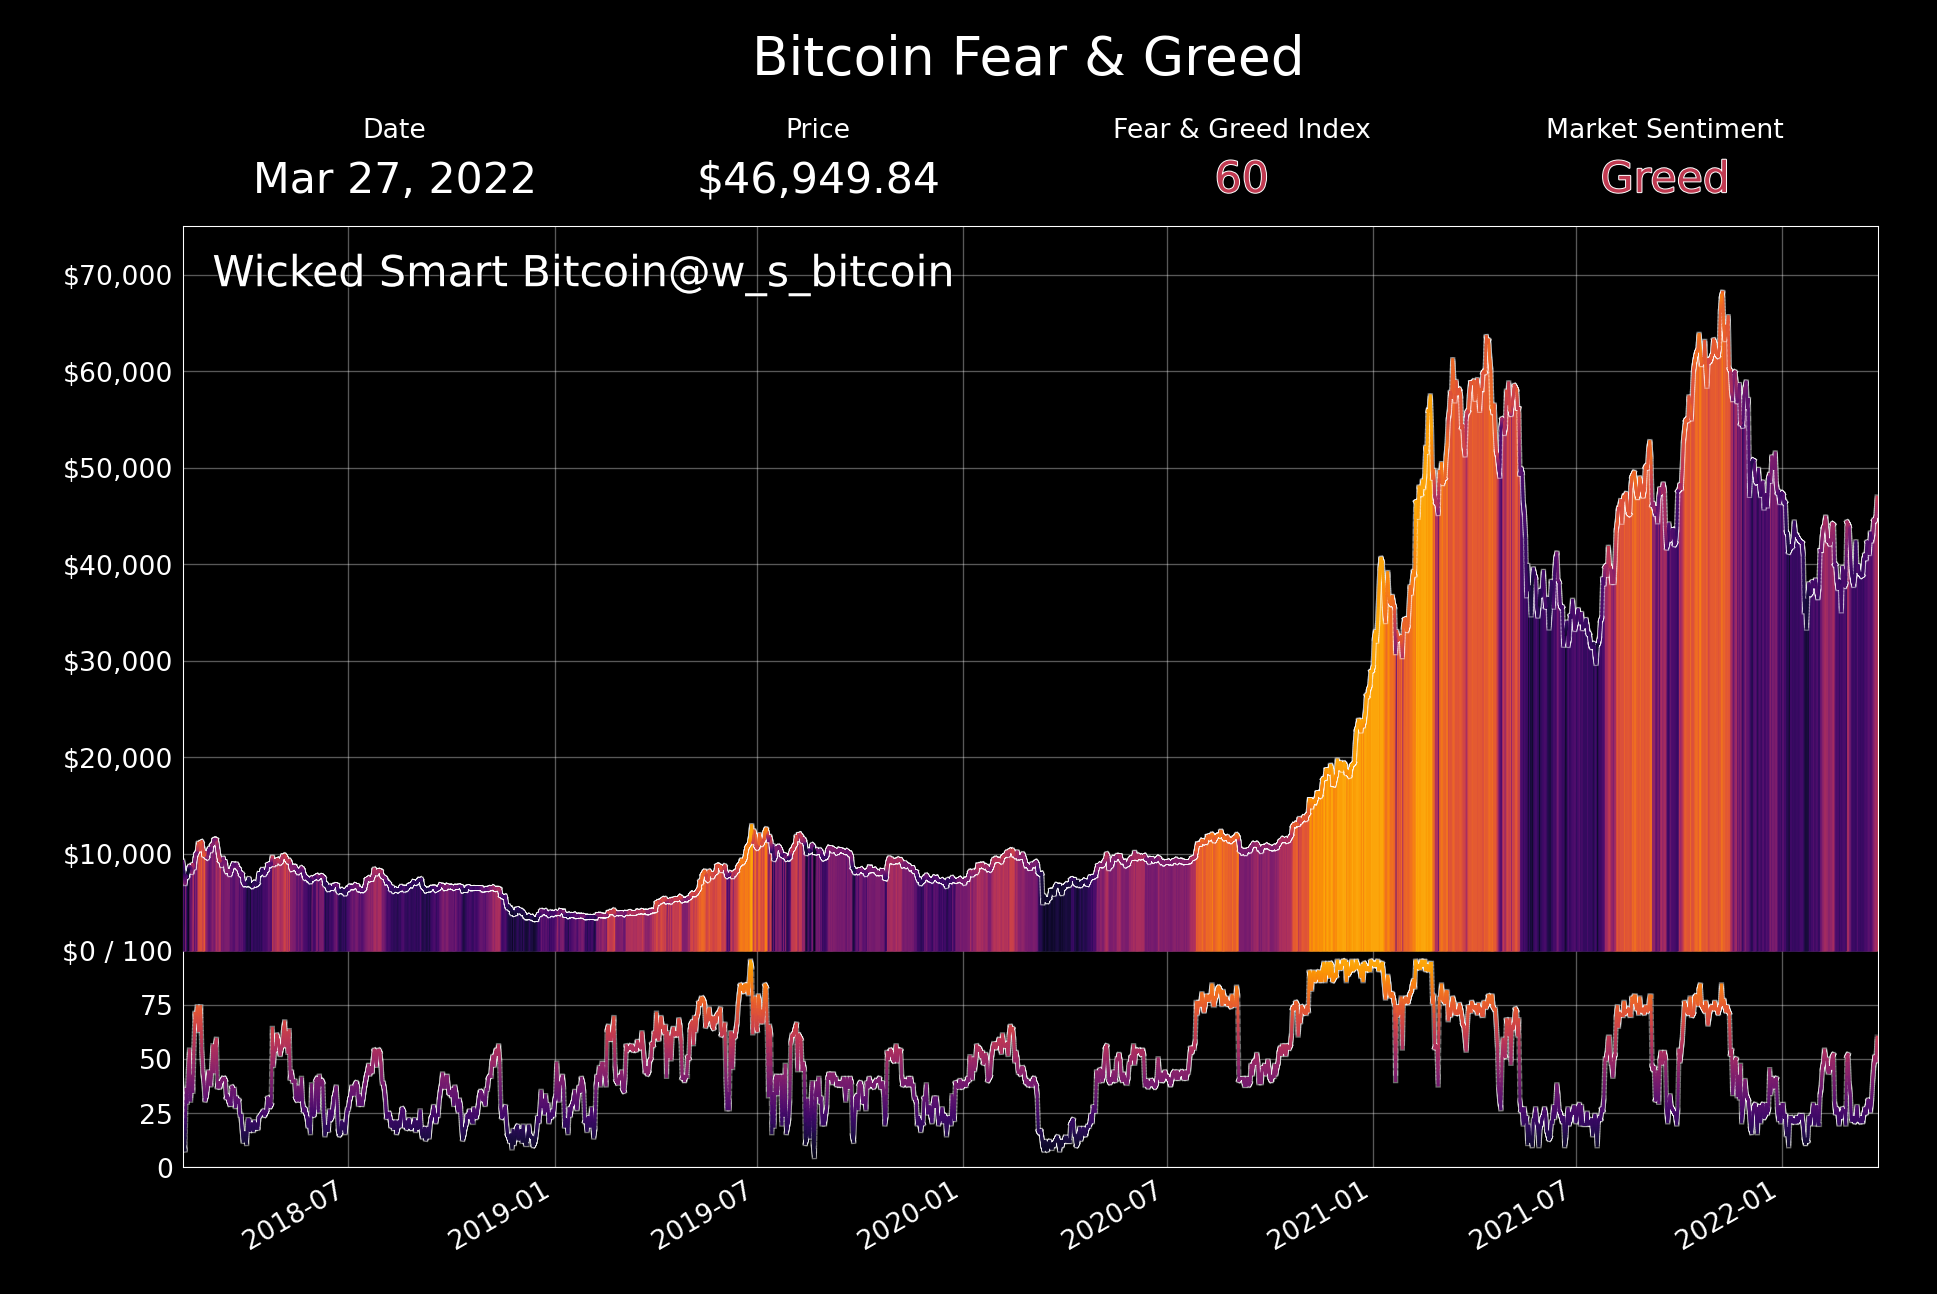

In [9]:
fg_plot_v2(list(orig_dates).index('01/31/18')+1)

In [ ]:
# for p in range(list(orig_dates).index('01/01/20')-185):
#     fg_plot(p+185)

In [ ]:
# # days = len(dates)
# days = 731
# x = dates[:days]
# y = fg_values[:days]
# z = np.array(y)

# cmap = cm.get_cmap('inferno', 100)
# mf = 0.85

# res = (1920, 1080)
# size = res[0]/96.
# size_y = res[1]/96.

# # create figure and axis objects with subplots()
# fig = plt.figure(figsize=(size, size_y), dpi=96)

# fig.patch.set_facecolor('white')
# plt.rc('axes', axisbelow=True)

# orig_price_dates = df['date']
# price_datetimes = str_to_datetime(orig_price_dates)
# price_dates = [mdates.date2num(date) for date in price_datetimes]
# prices = df['price']

# x = list(price_dates[-1*days:])
# x.reverse()
# y = list(prices[-1*days:])
# y.reverse()

# for i in range(100):
#     plt.fill_between(x, y, [m-max(y) for m in y], color=cmap(i/100.*mf),
#                      where=((z>=[i-1]*len(fg_values[:days])) & (z<[i+1]*len(fg_values[:days]))),
#                      interpolate=True)
# for i in range(100):
#     plt.fill_between(x, [m-max(y) for m in y], y, color=cmap(i/100.*mf),
#                      where=((z>=[i-1]*len(fg_values[:days])) & (z<[i+1]*len(fg_values[:days]))),
#                      interpolate=True)
# for i in range(100):
#     plt.fill_between([plt.xlim()[0]+0.08*(plt.xlim()[1]-plt.xlim()[0]),
#                       plt.xlim()[0]+0.105*(plt.xlim()[1]-plt.xlim()[0])],
#                      (0.415 + i/200)*max(y)*1.075,
#                      (0.425 + i/200)*max(y)*1.075, color=cmap(i/100.*mf))

# plt.text(plt.xlim()[0]+0.12*(plt.xlim()[1]-plt.xlim()[0]),
#          0.425*max(y)*1.075, 'Extreme', fontsize=18)
# plt.text(plt.xlim()[0]+0.12*(plt.xlim()[1]-plt.xlim()[0]),
#          0.39*max(y)*1.075, 'Fear', fontsize=18)
# plt.text(plt.xlim()[0]+0.12*(plt.xlim()[1]-plt.xlim()[0]),
#          0.925*max(y)*1.075, 'Extreme', fontsize=18)
# plt.text(plt.xlim()[0]+0.12*(plt.xlim()[1]-plt.xlim()[0]),
#          0.89*max(y)*1.075, 'Greed', fontsize=18)

# labels = ["$%s" % format(int(item), ',d') for item in [0, 10000, 20000, 30000, 40000, 50000,
#                                                        60000, 70000]]
# plt.yticks([0, 10000, 20000, 30000, 40000, 50000, 60000, 70000], labels, fontsize=20)
# plt.ylim(0, plt.ylim()[1])
# # plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
# plt.xticks(fontsize=20)
# plt.xlim(min(x), max(x))
# plt.title('Bitcoin: Two Years of Fear & Greed (%s - %s)' %
#           (orig_price_dates[-1*days:].to_list()[0], orig_price_dates[-1*days:].to_list()[-1]),
#           fontsize=28)
# plt.text(plt.xlim()[0]+0.99*(plt.xlim()[1]-plt.xlim()[0]),
#          0.025*max(y), 'Wicked Smart Bitcoin@w_s_bitcoin', fontsize=24,
#          horizontalalignment='right', color='white')

# plt.plot(x, y, color='#222', linewidth=1.5)

# plt.grid(color='#c8c8c8', ls='--', lw=1)

# x_axis_dates()

# fig.savefig('Bitcoin Two Years of Fear & Greed (1).png')

# plt.show()

In [ ]:
# res = (1920, 360)
# size = res[0]/96.
# size_y = res[1]/96.

# x = dates[:days]
# y = fg_values[:days]
# z = np.array(y)

# # create figure and axis objects with subplots()
# fig = plt.figure(figsize=(size, size_y), dpi=96)
# fig.patch.set_facecolor('white')

# xmin, xmax = plt.xlim()[0], plt.xlim()[1]
# plt.plot([xmin, xmax], [100, 100])
# plt.plot([xmin, xmax], [0, 0])


# # plt.plot([x[0], x[-1]], [25, 25], color='#c8c8c8', ls='--', lw=1)
# # plt.plot([x[0], x[-1]], [50, 50], color='#c8c8c8', ls='--', lw=1)
# # plt.plot([x[0], x[-1]], [75, 75], color='#c8c8c8', ls='--', lw=1)

# plt.grid(color='#c8c8c8', ls='--', lw=1)

# for i in range(len(x)-1):
#     for j in range(10):
#         plt.plot([x[i]+j*(x[i+1]-x[i])/10, x[i]+(j+1)*(x[i+1]-x[i])/10],
#                  [y[i]+j*(y[i+1]-y[i])/10, y[i]+(j+1)*(y[i+1]-y[i])/10],
#                  color=cmap((y[i]+j*(y[i+1]-y[i])/10)/100.*mf))
    
# # plt.text(x[-1], -50, '')

# plt.xlim(min(x), max(x))
# plt.ylim(0, 100)
# plt.yticks([0, 25, 50, 75, 100], [0, 25, 50, 75, 100], fontsize=20)
# plt.xticks(fontsize=20)
# x_axis_dates()

# fig.savefig('Bitcoin Two Years of Fear & Greed (2).png')

# plt.show()

In [ ]:
# # days = len(dates)
# days = 365
# x = dates[:days]
# y = fg_values[:days]
# z = np.array(y)

# cmap = cm.get_cmap('inferno', 100)
# mf = 0.85

# res = (1920, 1080)
# size = res[0]/96.
# size_y = res[1]/96.

# # create figure and axis objects with subplots()
# fig = plt.figure(figsize=(size, size_y), dpi=96)

# fig.patch.set_facecolor('white')
# plt.rc('axes', axisbelow=True)

# orig_price_dates = df['date']
# price_datetimes = str_to_datetime(orig_price_dates)
# price_dates = [mdates.date2num(date) for date in price_datetimes]
# prices = df['price']

# x = list(price_dates[-1*days:])
# x.reverse()
# y = list(prices[-1*days:])
# y.reverse()

# for i in range(100):
#     plt.fill_between(x, y, [m-max(y) for m in y], color=cmap(i/100.*mf),
#                      where=((z>=[i-1]*len(fg_values[:days])) & (z<[i+1]*len(fg_values[:days]))),
#                      interpolate=True)
# for i in range(100):
#     plt.fill_between(x, [m-max(y) for m in y], y, color=cmap(i/100.*mf),
#                      where=((z>=[i-1]*len(fg_values[:days])) & (z<[i+1]*len(fg_values[:days]))),
#                      interpolate=True)
# for i in range(100):
#     plt.fill_between([plt.xlim()[0]+0.08*(plt.xlim()[1]-plt.xlim()[0]),
#                       plt.xlim()[0]+0.105*(plt.xlim()[1]-plt.xlim()[0])],
#                      (0.415 + i/200)*max(y)*1.075,
#                      (0.425 + i/200)*max(y)*1.075, color=cmap(i/100.*mf))

# plt.text(plt.xlim()[0]+0.12*(plt.xlim()[1]-plt.xlim()[0]),
#          0.425*max(y)*1.075, 'Extreme', fontsize=18)
# plt.text(plt.xlim()[0]+0.12*(plt.xlim()[1]-plt.xlim()[0]),
#          0.39*max(y)*1.075, 'Fear', fontsize=18)
# plt.text(plt.xlim()[0]+0.12*(plt.xlim()[1]-plt.xlim()[0]),
#          0.925*max(y)*1.075, 'Extreme', fontsize=18)
# plt.text(plt.xlim()[0]+0.12*(plt.xlim()[1]-plt.xlim()[0]),
#          0.89*max(y)*1.075, 'Greed', fontsize=18)

# labels = ["$%s" % format(int(item), ',d') for item in [0, 10000, 20000, 30000, 40000, 50000,
#                                                        60000, 70000]]
# plt.yticks([0, 10000, 20000, 30000, 40000, 50000, 60000, 70000], labels, fontsize=20)
# plt.ylim(0, plt.ylim()[1])
# # plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
# plt.xticks(fontsize=20)
# plt.xlim(min(x), max(x))
# plt.title('Bitcoin: One Year of Fear & Greed (%s - %s)' %
#           (orig_price_dates[-1*days:].to_list()[0], orig_price_dates[-1*days:].to_list()[-1]),
#           fontsize=28)
# plt.text(plt.xlim()[0]+0.99*(plt.xlim()[1]-plt.xlim()[0]),
#          0.025*max(y), 'Wicked Smart Bitcoin@w_s_bitcoin', fontsize=24,
#          horizontalalignment='right', color='white')

# plt.plot(x, y, color='#222', linewidth=1.5)

# plt.grid(color='#c8c8c8', ls='--', lw=1)

# x_axis_dates()

# fig.savefig('Bitcoin One Year of Fear & Greed (1).png')

# plt.show()

In [ ]:
# res = (1920, 360)
# size = res[0]/96.
# size_y = res[1]/96.

# x = dates[:days]
# y = fg_values[:days]
# z = np.array(y)

# # create figure and axis objects with subplots()
# fig = plt.figure(figsize=(size, size_y), dpi=96)
# fig.patch.set_facecolor('white')

# xmin, xmax = plt.xlim()[0], plt.xlim()[1]
# plt.plot([xmin, xmax], [100, 100])
# plt.plot([xmin, xmax], [0, 0])


# # plt.plot([x[0], x[-1]], [25, 25], color='#c8c8c8', ls='--', lw=1)
# # plt.plot([x[0], x[-1]], [50, 50], color='#c8c8c8', ls='--', lw=1)
# # plt.plot([x[0], x[-1]], [75, 75], color='#c8c8c8', ls='--', lw=1)

# plt.grid(color='#c8c8c8', ls='--', lw=1)

# for i in range(len(x)-1):
#     for j in range(10):
#         plt.plot([x[i]+j*(x[i+1]-x[i])/10, x[i]+(j+1)*(x[i+1]-x[i])/10],
#                  [y[i]+j*(y[i+1]-y[i])/10, y[i]+(j+1)*(y[i+1]-y[i])/10],
#                  color=cmap((y[i]+j*(y[i+1]-y[i])/10)/100.*mf), lw=2)
    
# # plt.text(x[-1], -50, '')


# plt.xlim(min(x), max(x))
# plt.ylim(0, 100)
# plt.yticks([0, 25, 50, 75, 100], [0, 25, 50, 75, 100], fontsize=20)
# plt.xticks(fontsize=20)
# x_axis_dates()

# fig.savefig('Bitcoin One Year of Fear & Greed (2).png')

# plt.show()

In [ ]:
# # days = len(dates)
# days = len(dates)
# x = dates[:days]
# y = fg_values[:days]
# z = np.array(y)

# cmap = cm.get_cmap('inferno', 100)
# mf = 0.85

# res = (1920, 1080)
# size = res[0]/96.
# size_y = res[1]/96.

# # create figure and axis objects with subplots()
# fig = plt.figure(figsize=(size, size_y), dpi=96)

# fig.patch.set_facecolor('white')
# plt.rc('axes', axisbelow=True)

# orig_price_dates = df['date']
# price_datetimes = str_to_datetime(orig_price_dates)
# price_dates = [mdates.date2num(date) for date in price_datetimes]
# prices = df['price']

# x = list(price_dates[-1*days:])
# x.reverse()
# y = list(prices[-1*days:])
# y.reverse()

# for i in range(100):
#     plt.fill_between(x, y, [m-max(y) for m in y], color=cmap(i/100.*mf),
#                      where=((z>=[i-1]*len(fg_values[:days])) & (z<[i+1]*len(fg_values[:days]))),
#                      interpolate=True)
# for i in range(100):
#     plt.fill_between(x, [m-max(y) for m in y], y, color=cmap(i/100.*mf),
#                      where=((z>=[i-1]*len(fg_values[:days])) & (z<[i+1]*len(fg_values[:days]))),
#                      interpolate=True)
# for i in range(100):
#     plt.fill_between([plt.xlim()[0]+0.08*(plt.xlim()[1]-plt.xlim()[0]),
#                       plt.xlim()[0]+0.105*(plt.xlim()[1]-plt.xlim()[0])],
#                      (0.415 + i/200)*max(y)*1.075,
#                      (0.425 + i/200)*max(y)*1.075, color=cmap(i/100.*mf))

# plt.text(plt.xlim()[0]+0.12*(plt.xlim()[1]-plt.xlim()[0]),
#          0.425*max(y)*1.075, 'Extreme', fontsize=18)
# plt.text(plt.xlim()[0]+0.12*(plt.xlim()[1]-plt.xlim()[0]),
#          0.39*max(y)*1.075, 'Fear', fontsize=18)
# plt.text(plt.xlim()[0]+0.12*(plt.xlim()[1]-plt.xlim()[0]),
#          0.925*max(y)*1.075, 'Extreme', fontsize=18)
# plt.text(plt.xlim()[0]+0.12*(plt.xlim()[1]-plt.xlim()[0]),
#          0.89*max(y)*1.075, 'Greed', fontsize=18)

# labels = ["$%s" % format(int(item), ',d') for item in [0, 10000, 20000, 30000, 40000, 50000,
#                                                        60000, 70000]]
# plt.yticks([0, 10000, 20000, 30000, 40000, 50000, 60000, 70000], labels, fontsize=20)
# plt.ylim(0, plt.ylim()[1])
# # plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
# plt.xticks(fontsize=20)
# plt.xlim(min(x), max(x))
# plt.title('Bitcoin Fear & Greed (%s - %s)' %
#           (orig_price_dates[-1*days:].to_list()[0], orig_price_dates[-1*days:].to_list()[-1]),
#           fontsize=28)
# plt.text(plt.xlim()[0]+0.99*(plt.xlim()[1]-plt.xlim()[0]),
#          0.025*max(y), 'Wicked Smart Bitcoin@w_s_bitcoin', fontsize=24,
#          horizontalalignment='right', color='white')
# plt.plot(x, y, color='#222', linewidth=1.5)
# plt.grid(color='#c8c8c8', ls='--', lw=1)
# x_axis_dates()
# plt.show()

In [ ]:
# res = (1920, 360)
# size = res[0]/96.
# size_y = res[1]/96.

# x = dates[:days]
# y = fg_values[:days]
# z = np.array(y)

# # create figure and axis objects with subplots()
# fig = plt.figure(figsize=(size, size_y), dpi=96)
# fig.patch.set_facecolor('white')

# xmin, xmax = plt.xlim()[0], plt.xlim()[1]
# plt.plot([xmin, xmax], [100, 100])
# plt.plot([xmin, xmax], [0, 0])


# # plt.plot([x[0], x[-1]], [25, 25], color='#c8c8c8', ls='--', lw=1)
# # plt.plot([x[0], x[-1]], [50, 50], color='#c8c8c8', ls='--', lw=1)
# # plt.plot([x[0], x[-1]], [75, 75], color='#c8c8c8', ls='--', lw=1)

# plt.grid(color='#c8c8c8', ls='--', lw=1)

# for i in range(len(x)-1):
#     for j in range(10):
#         plt.plot([x[i]+j*(x[i+1]-x[i])/10, x[i]+(j+1)*(x[i+1]-x[i])/10],
#                  [y[i]+j*(y[i+1]-y[i])/10, y[i]+(j+1)*(y[i+1]-y[i])/10],
#                  color=cmap((y[i]+j*(y[i+1]-y[i])/10)/100.*mf), lw=1)
    
# plt.xlim(min(x), max(x))
# plt.ylim(0, 100)
# plt.yticks([0, 25, 50, 75, 100], [0, 25, 50, 75, 100], fontsize=20)
# plt.xticks(fontsize=20)
# x_axis_dates()
# plt.show()